# Introduction
For this example of how to use MAVEN data, we're going to explore some of the data that played a staring role in one of the first major MAVEN papers: 

__["MAVEN observations of the response of Mars to an interplanetary coronal mass ejection"](https://www.science.org/doi/10.1126/science.aad0210)__

In this paper, Jakosky *et al.* use MAVEN data to show how Mars' atmsophere responded to the arrival of a large solar storm in March of 2015. 

While we're not going to be nearly as rigorous as the paper was with our analysis, we should be able to clearly see the large spike in components of the atmosphere leaving Mars. 

# The Solar Flare
First, lets take a look at some of the "Key Parameter" data. The Key Parameter data contain a high-level summary of all of the MAVEN data, averaged over 4 to 8 seconds. 

The data is structured as a text file, with each row corresponding to a different time, and each of the 235 columns represent a different data point. Each file contains one day of data. This makes the python pandas library an excellent fit for reading in the data. 

> **_NOTE:_**  More information about the structure of KP files can be found here: https://lasp.colorado.edu/maven/sdc/public/data/sdc/web/instrument_docs/kp/maven_sis_kp_insitu_r05.pdf. 


In [1]:
import pandas as pd

data = pd.read_fwf("mvn_kp_insitu_20150306_v23_r01.tab",
                   skiprows=351, # The first 351 rows of the file describe the data 
                   header=None) # We'll ignore the names of each column for now

There was a large solar flare that erupted on March 6th 2015. This flare was observed by the EUV (Extreme Ultraviolet) instrument on board MAVEN. The EUV instrument measures the extreme ultraviolet rays from the sun, which dramatically increase when there is a solar flare observed. 

We can clearly see this increase in the plot below: 


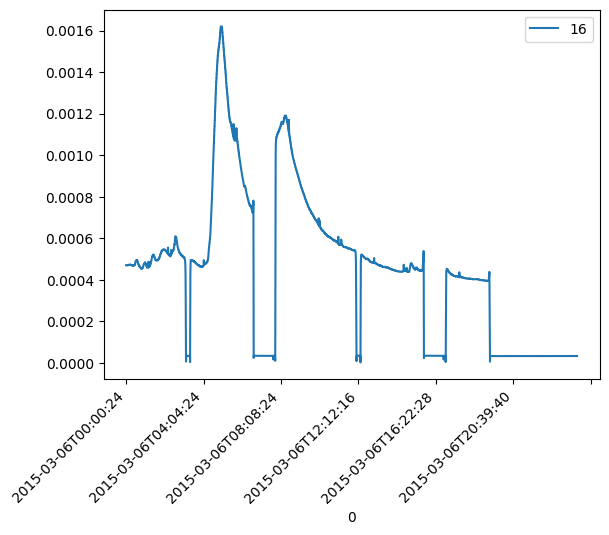

In [2]:
from matplotlib import pyplot
data.plot(x=0, y=16) # Column 0 is time, and column 16 is EUV data
pyplot.xticks(rotation=45, ha='right') # Need this to make the dates actually visible
pyplot.show()

At about 4:30 UTC, you can see there a large spike in activity, which slowly decreases back down to its previous level. 

# The Coronal Mass Ejection

Solar flares are typically associated with an ejection of plasma from the sun, also known as a Coronal Mass Ejection (CME). As it happens, the CME associated with this solar flare was pointed directly at Mars. 

Since it takes a few days for a CME to travel from the Sun all the way to Mars, we can inspect KP data a few days later to see if we can determine when the CME arrived. 

In [3]:
data = pd.read_fwf("mvn_kp_insitu_20150308_v23_r01.tab",
            skiprows=351,
            header=None)

MAVEN's Solar Energetic Particles (SEP) instrument measures, you guessed it, Solar Energetic Particles! It does so across 4 different detectors. Below, we'll sum up the data from all 4 detectors and plot it, so we can get an idea of when the CME reached Mars.


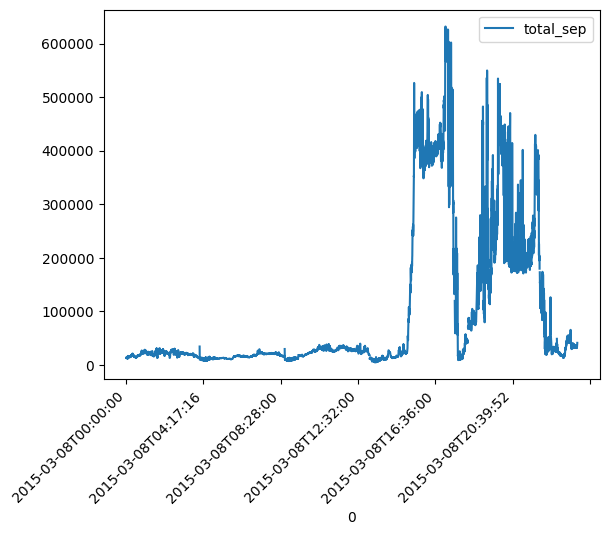

In [4]:
data['total_sep'] = data[99] + data[101] + data[103] + data[105] # Columns 99,101, 103, and 105 are data from the 4 different SEP detectors. 
data.plot(x=0, y='total_sep')
pyplot.xticks(rotation=45, ha='right')
pyplot.show()

Yowza! The total flux of Solar Energetic Particles increases by a factor of >10x at around 14:00 on March 8th, about 2.5 days after the solar flare. 


# Mars' Response to the CME

Now our goal is to see if there was an increase in Mars' atmosphere being stripped away during this CME event. 

Doing so is out of the capabilities of the KP data. The KP data *does* summarize the total flux detected over time, as you can see when you plot it:

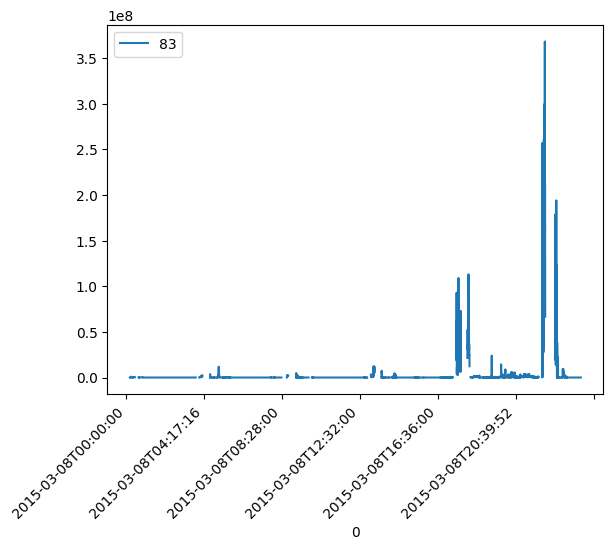

In [5]:
data.plot(x=0, y=83) # Column 83 is Oxygen ion flux measured by STATIC
pyplot.xticks(rotation=45, ha='right')
pyplot.show()

But it does **not** reveal the direction of the flux, nor break it down by energy or aggregate by mass. 

A more rigorous analysis of the data requires going into the CDF (Common Data Format) files. 

> **_NOTE:_**  CDF files are widely used in Heliophysics, and it is the most common data format on MAVEN. Data from 7 of the 9 intruments are in this CDF file format. CDF shares a common lineage with netCDF files, and both serve the same purpose of storing high-dimensional data sets. 

To read in these CDF files, we'll use the python library "cdflib" to convert the data in a file to an XArray object:

In [6]:
from cdflib.xarray import cdf_to_xarray
sta = cdf_to_xarray("mvn_sta_l2_d0-32e4d16a8m_20150308_v02_r01.cdf") 
print(sta)


<xarray.Dataset> Size: 180MB
Dimensions:               (epoch: 591, compno_3: 3, compno_4: 4, dim0: 64,
                           compno_8: 8, compno_64: 64, compno_32: 32, dim1: 8,
                           dim2: 32, dim3: 27, dim4: 4, dim5: 128, dim6: 9)
Coordinates: (12/22)
  * epoch                 (epoch) datetime64[ns] 5kB 2015-03-08T00:15:17.8954...
  * compno_3              (compno_3) int16 6B 1 2 3
    magf_labl             (compno_3) <U2 24B 'Bx' 'By' 'Bz'
    pos_sc_mso_labl       (compno_3) <U7 84B 'X (MSO)' 'Y (MSO)' 'Z (MSO)'
  * compno_4              (compno_4) int16 8B 1 2 3 4
    quat_sc_labl          (compno_4) <U7 112B 'Q1 (SC)' 'Q2 (SC)' ... 'Q4 (SC)'
    ...                    ...
    eflux_energy_labl_32  (compno_32) <U14 2kB ' eflux@ENERGY0' ... 'eflux@EN...
  * compno_64             (compno_64) int16 128B 1 2 3 4 5 6 ... 60 61 62 63 64
    bkg_bin_labl_64       (compno_64) <U9 2kB ' bkg@BIN0' ... 'bkg@BIN63'
    dead_bin_labl_64      (compno_64) <U10 3kB ' dea

We just loaded in STATIC data from March 8th 2015. STATIC (Suprathermal and Thermal Ion Composition) measures ion counts across various directions, energies, and masses. The primary data taken by the instrument is therefore 4 dimensional (time, direction, energy, and mass)

Data from this instrument is how Jakosky *et al.* determined that the atmospheric loss greatly increased during the CME. 

Now one thing we *could* do is sum up the data across all directions, energies, and masses, just to get a total count of anything entering the detector over time


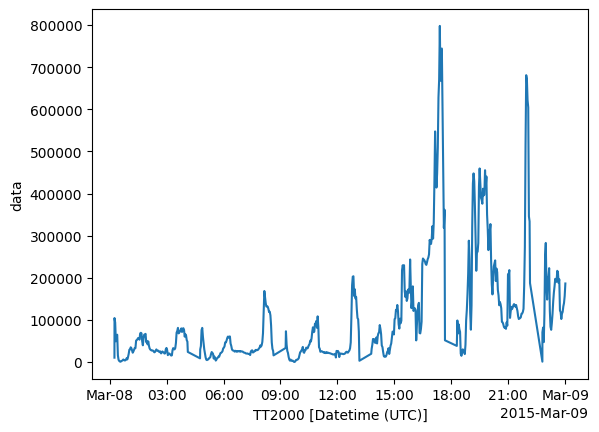

In [7]:
sta['data'].sum(dim='compno_64').sum(dim='compno_32').sum(dim='compno_8').plot()
pyplot.show()

It definitely looks like there is an increase in the number of ion detections around the time of the CME, but if we want to even get close to the data in the paper, we need to follow the following steps:

1) Retrieve the flux of the data (rather than counts)
2) Determine the direction that each directional bin of STATIC points, especially if it points *towards* versus *away* from Mars 
3) Filter out lower energies of detections from the data
4) Filter out lower mass ions from the data
5) Aggregate the flux by the direction the ions are facing.

These steps will all be performed below.

### 1) Retrieving the Flux 

The eflux variable adjusts the counts by integration time, accounts for background detections, dead time, and the geometric shape of the instrument to determine a count per steradian per second:

In [8]:
data = sta['eflux']

Next we need to make sure the data is all relatively consistent. STATIC can load in different "sweep tables" that describe the table of masses and energies that the instrument is binning its detections by. The variable "swp_ind" respresents the currently loaded table. 

Thankfully most of the STATIC data for March 8th is in similar sweep tables (17 & 19), except for one data point which uses a sweep table that is wildly different from the rest (16). Booo. So lets just ignore it, since it'll mess with the simplicity of some of the future filtering. 


In [9]:
data = data.where(sta['swp_ind']!=16)

Additionally, STATIC also has 6 operating modes to choose from. Jakosky *et al.* only selected STATIC data where the instrument was configured for "pickup ion" mode (the most common and "default" mode for the instrument to be in). 

In [10]:
data = data.where(sta['mode']==3)

### 2) Determining the Direction of the Ion Flow

To determine the direction that the ions came from, we need to 
1) Pull out the theta/phi angles that each of the 64 directions represent
2) Convert these theta/phi angles into unit vectors in x/y/z space. 
3) Use a quaternion within the dataset to convert the above unit vectors into the Mars Solar Orbit coordinate system
4) Use the spacecraft's position in MSO coordinates to determine if a particular direction bin is generally pointed in the direction towards mars, or away from Mars. 

Forgive me, but this will be a massive block of code. 

In [11]:
import numpy as np
from scipy.spatial.transform import Rotation
import xarray as xr

# Technically theta/phi are slightly dependent on mass, energy, and the currently set sweep table (given by the variable "swp_ind"), but since these effects are slight we'll ignore them.
# This is why we select only from dim1/dim2/dim3 = 0.  
theta_degrees = (sta['theta'].isel(dim1=0, dim2=0, dim3=0))
phi_degrees = sta['phi'].isel(dim1=0, dim2=0, dim3=0) 

# Convert theta/phi to radians
theta = theta_degrees  * np.pi / 180 
phi = phi_degrees * np.pi / 180

# Convert theta/phi to x/y/z coordinates
z_static = np.sin(theta)
y_static = np.cos(theta) * np.sin(phi)
x_static = np.cos(theta) * np.cos(phi)

# Create a new array of these x/y/z vectors
# This is a 64 element array, each with a vector of size 3 representing the x/y/z coordinates. 
V_bins_static = np.stack([x_static, y_static, z_static], axis=1)

away_masks=[]
# Loop through each time in the dataset
for t in range(len(sta['epoch'])):

    # Get the quaternion for this time step
    q_mso = sta['quat_mso'][t] 

    # Create the Scipy Rotation object
    R_mso = Rotation.from_quat(q_mso)

    # Apply the rotation to all vectors
    V_bins_mso = R_mso.apply(V_bins_static)
    
    # Get the "away from Mars" vector, with respect to the spacecraft
    P_mso = sta['pos_sc_mso'][t]
    V_away_mso = P_mso / np.linalg.norm(P_mso)

    # Find "away" bins using the dot product
    dot_products = np.dot(V_bins_mso, V_away_mso)
    away_mask = dot_products > 0
    away_masks.append(away_mask)

# Create a new "pointing_away" dataarray that is True if a direction bin at a particular time is pointed away from Mars, or False if pointed toward Mars. 
sta['pointing_away'] = xr.DataArray(away_masks, dims=('epoch', 'compno_64'))

Ok sorry about all that geometry, but that was definitely the most intense part of the tutorial. 

### 3) Filtering small energies

Now we need to filter out small energies, as was done in the MAVEN paper. In our dataset object, the "compno_32" dimension contains information about the 32 energy bins that are being binned by STATIC. Indexes 20 to 31 represent energy bins that are below 25eV (at least when sweep table 17 & 19 are active).

In [12]:
data = data.isel(compno_32=slice(0,19))

After selecting for only the high energy ions, we'll sum all of the energies up to get a flux of only the high energy ions:

In [13]:
data = data.sum(dim='compno_32')

### 4) Filtering small masses

The compno_8 dimension contains information about the 8 mass bins. In sweep modes 17 and 19, indexes 0, 1, and 2 contain masses below what we are interested in (9 Atomic Mass Units). In otherwords, we don't care about Hydrogen, Helium, or Lithium. I guess those were *boring* (not to be confused *boron*, which is acceptable).

In [14]:
data = data.isel(compno_8=slice(3,8))

And finally, we sum over the the remaining masses to get a flux of all the higher mass ions:

In [15]:
data = data.sum(dim='compno_8')

### 5) Filtering flux by direction

Finally, here we are, the last few steps! To recap, right now, the variable __data__ represents the flux of heavy, high energy ions, binned by both time and by direction. 

Since the new "pointing_away" variable we calculated in step 2 contains information about which directional bins are pointed *away* from Mars and which are *towards* it, we can use that to filter out the data:

In [16]:
flux_away_from_mars = data.where(sta['pointing_away']).sum(dim='compno_64') 
flux_towards_mars = data.where(~sta['pointing_away']).sum(dim='compno_64')

And we can put them on the same plot:

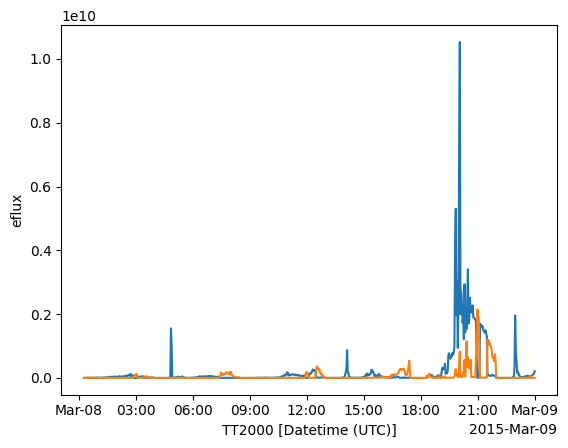

In [17]:
flux_away_from_mars.plot()
flux_towards_mars.plot()
pyplot.show()

This final plot shows that the flux of ions going away from mars increases dramatically at around the time the CME hits Mars, and the flux of ions going toward Mars, while increased, is nowhere near enough to make up for the decrease.

# Summary

This is far from a robust analysis of the data. Jakosky *et al.* actually used a slightly different STATIC file where the data was taken more rapidly (a "d1" file rather than a "d0" file). They determine the ion flux rate only in a shell ~800km to ~1500km above the surface of Mars. And they also converted data to a coordinate system dependent on the interstellar magnetic field, rather than the MSO coordinate system we used.   

However, we have learned a few important things:

1) How to open up the KP data, and explore and plot the data within the file.
2) How to open up a CDF file, convert it to xarray, and then perform some preliminary analysis and plotting with xarray. 


Keep in mind, the breadth of the MAVEN data extends **far** beyond this simple demo. MAVEN contains 8 other equally important instruments/sensors on board that we didn't touch here, including an ultraviolet spectrometer (IUVS) which actually contains the plurality of MAVEN data. 
